# Pipeline Main Workflow

This file defines the main (scaffold) workflow fo the pipeline. The tractorgraphy building block is intended to be freely exchangeable

In [1]:
# Debug stuff! Remove this cell once you're done Simon!
import sys
sys.path.append("/Users/srothmei/Documents/TVB-Pypeline/")

In [2]:
from nipype import Node, Workflow, MapNode
from nipype.interfaces.utility import IdentityInterface, Function
import bm_functions as brainmodes
import logging

### Inputs parameters

In [3]:
# Later get these from a function input or similar
subject_id = 'FR_20120903'
subject_folder = '/Users/srothmei/Desktop/charite/toronto/'

### Setup

In [4]:
inputNode = Node(IdentityInterface(fields = ['subject_folder', 'subject_id']),
                name = 'input_node')

inputNode.inputs.subject_folder = subject_folder
inputNode.inputs.subject_id = subject_id

### Logging

In [5]:
logging.basicConfig(filename = subject_folder + subject_id + '/pipeline.log', level=logging.DEBUG)

### Utiliy functions

In [6]:
def roiRange(number_of_rois):
    return range(1,number_of_rois + 1)

## Preprocessing

In [7]:
import preprocSub as preprocessing

## Functional processing

In [8]:
#funcProcNode = Node(Function(input_names= ['path', 'subName'],
#                            output_names = [],
#                            function = brainmodes.compute_functional_connectivity),
#                    name = 'functional_processing')

## Tractography-Mask generation

In [9]:
maskGenNode = Node(Function(input_names = ['subPath',
                                           'mask_output_folder',
                                           'wmoutline2diff_1mm',
                                           'wmparc2diff_1mm',
                                           'seedsPerVoxel'],
                           output_names = ['seed_target_masks', 'seed_count',
                                           'number_of_rois', 'affine_matrix',
                                          'wmborder_data'],
                           function = brainmodes.generate_masks),
                   name = 'generate_masks')

maskGenNode.inputs.seedsPerVoxel = 200

## Tracking

In [10]:
import mrtrix as mrtrix

## Connectivity

In [15]:
connectivityRowNode = MapNode(Function(input_names = ['roi', 
                                                      'subid', 
                                                      'affine_matrix',
                                                      'wmborder', 
                                                      'tracksPath', 'track_files'],
                                   output_names = ['SC_cap_row_filename', 'SC_dist_row_filename'],
                                   function = brainmodes.compute_connectivity_row),
                            name = 'comp_SC_row',
                            iterfield = ['roi'])

aggregateConnectivityNode = Node(Function(input_names = ['sub_id',
                                                         'wmborder',
                                                         'tracksPath',
                                                         'cap_row_files',
                                                         'dist_row_files',
                                                         'steplength'],
                                         output_names = [],
                                         function = brainmodes.aggregate_connectivity),
                                name = 'aggregate_SC')

# Incorporate the step size used during tracking (default 0.2 mm)
aggregateConnectivityNode.inputs.steplength = mrtrix.mrtrix_tracking.trackingNode.inputs.step_size

0.2

## TVB formatting


## Build the Workflow

In [18]:
wf = Workflow(name = 'TVB_pipeline')

wf.connect([
        (inputNode, preprocessing.wf, [('subject_folder', 'input_node.subject_folder'),
                                      ('subject_id', 'input_node.subject_id')]),
        (preprocessing.wf, maskGenNode, [('output_node.subPath', 'subPath'),
                                        ('output_node.mask_folder', 'mask_output_folder'),
                                        ('output_node.wmoutline2diff_1mm', 'wmoutline2diff_1mm'),
                                        ('output_node.wmparc2diff_1mm', 'wmparc2diff_1mm')]),
        (maskGenNode, mrtrix.mrtrix_main.wf, [('seed_target_masks', 'input_node.seed_target_masks'),
                                             ('seed_count', 'input_node.seed_count')]),
        (preprocessing.wf, mrtrix.mrtrix_main.wf, [('output_node.bval_file', 'input_node.bval_file'),
                                                  ('output_node.bvec_file', 'input_node.bvec_file'),
                                                  ('output_node.dwi_file', 'input_node.dwi_file'),
                                                  ('output_node.trackingFolder', 'input_node.tracking_dir'),
                                                  ('output_node.tracks_folder', 'input_node.tracks_dir'),
                                                  ('output_node.highresWmMask', 'input_node.wmmask_1mm'),
                                                  ('output_node.lowresWmMask', 'input_node.wmmask')]),
        (maskGenNode, connectivityRowNode, [(('number_of_rois', roiRange), 'roi'),
                                           ('affine_matrix', 'affine_matrix'),
                                           ('wmborder_data', 'wmborder')]),
        (inputNode, connectivityRowNode, [('subject_id', 'subid')]),
        (preprocessing.wf, connectivityRowNode, [('output_node.tracks_folder', 'tracksPath')]),
        (mrtrix.mrtrix_main.wf, connectivityRowNode, [('output_node.trk_files', 'track_files')]),
        (inputNode, aggregateConnectivityNode, [('subject_id', 'sub_id')]),
        (maskGenNode, aggregateConnectivityNode, [('wmborder_data', 'wmborder')]),
        (preprocessing.wf, aggregateConnectivityNode, [('output_node.tracks_folder', 'tracksPath')]),
        (connectivityRowNode, aggregateConnectivityNode, [('SC_cap_row_filename', 'cap_row_files'),
                                                         ('SC_dist_row_filename', 'dist_row_files')])
    ])

## Run the Workflow

2015-11-25 16:39:30,547 - INFO - Creating detailed dot file: /Users/srothmei/Documents/TVB-Pypeline/notebooks/workflow_graph_detailed.dot
INFO:workflow:Creating detailed dot file: /Users/srothmei/Documents/TVB-Pypeline/notebooks/workflow_graph_detailed.dot
2015-11-25 16:39:31,454 - INFO - Creating dot file: /Users/srothmei/Documents/TVB-Pypeline/notebooks/workflow_graph.dot
INFO:workflow:Creating dot file: /Users/srothmei/Documents/TVB-Pypeline/notebooks/workflow_graph.dot


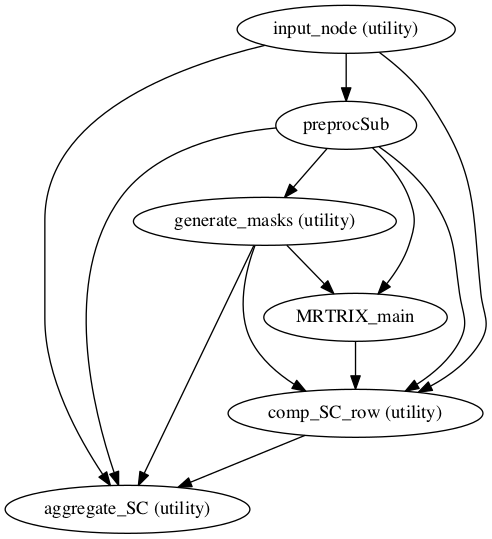

In [19]:
wf.write_graph("workflow_graph.dot", graph2use = 'orig')
from IPython.display import Image
Image(filename="workflow_graph.dot.png")